In [1]:
import meep as mp
import meep.adjoint as mpa
import numpy as np
from autograd import numpy as npa
from autograd import tensor_jacobian_product, grad
import nlopt
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
import math

from meep.materials import Ag

In [2]:
lambda_min = 0.4       # 최소 파장 (µm)
lambda_max = 0.7       # 최대 파장 (µm)
fmin = 1/lambda_max    # 최소 주파수
fmax = 1/lambda_min    # 최대 주파수
fcen = 0.5*(fmin+fmax) # 중앙 주파수
df = fmax-fmin         # 주파수 대역폭

resolution = 50        # 시뮬레이션 해상도
nfreq = 1             # 추출할 주파수 개수
design_region_resolution = 50

In [3]:
tag_bot         = 0.5
tag_side        = 4
tsio2           = 4
tdesignregion   = 1
monitor_position = 1 / fcen
monitor_blank   = 1 / fcen * 0.1

tpml = 0.4

width_ag = 0.2
width_sio2 = 2

width_bot_ag = width_ag+width_sio2+width_ag

design_region_width = round(width_bot_ag, 3)
design_region_height = 1

Sx = tpml+width_bot_ag+tpml
Sy = tag_bot+tag_side+tdesignregion+monitor_position+monitor_blank+tpml

SiO2 = mp.Medium(index = 1.45)
TiO2 = mp.Medium(index = 2.6)

Nx = int(design_region_resolution * design_region_width) + 1
Ny = int(design_region_resolution * design_region_height) + 1

y_bottom = -Sy/2
center_y_ag = y_bottom + tag_bot / 2
center_y_sio2 = y_bottom + tag_bot + tsio2 / 2
center_y_design = y_bottom + tag_bot + tsio2 + design_region_height / 2
center_y_monitor_position = y_bottom + tag_bot + tsio2 + design_region_height + 1/fcen
center_y_source_position = y_bottom + tag_bot + 1/fcen 
center_Ag_x_position = design_region_width/2-width_ag/2 #+ tpml/2

design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), TiO2, SiO2,  grid_type="U_MEAN")

design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)


boundary_layers = [mp.Absorber(tpml,direction=mp.X),
                   mp.PML(tpml,direction=mp.Y,side=mp.High)]

In [4]:
cell_size = mp.Vector3(Sx, Sy)
geometry = [
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_bot_ag, tag_bot, 0),
        center=mp.Vector3(0, center_y_ag, 0)
    ),
    mp.Block(
        material=SiO2,
        size=mp.Vector3(width_sio2, tsio2, 0),
        center=mp.Vector3(0, center_y_sio2, 0)
    ),
    mp.Block(
        material=design_variables,
        size=mp.Vector3(design_region_width, design_region_height, 0),
        center=mp.Vector3(0, center_y_design, 0)
    ),

    ######### Side metal ########## 
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(-center_Ag_x_position, center_y_sio2, 0)
    ),
    mp.Block(
        material=Ag,
        size=mp.Vector3(width_ag, tsio2, 0),
        center=mp.Vector3(center_Ag_x_position, center_y_sio2, 0)
    ),
]

In [5]:
src = mp.GaussianSource(frequency=fcen, fwidth=df, is_integrated=True)

sources = mp.Source(
            src,
            component=mp.Ez,
            center=mp.Vector3(
                0,
                center_y_source_position,  # Alq3 층의 중간 높이
                0
            )
        )


sim = mp.Simulation(
    resolution=resolution,
    sources=[sources],
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    default_material=mp.Medium(index = 1),
    extra_materials=[Ag]
)

In [6]:
# dft_fields = sim.add_dft_fields([mp.Ez], fcen, 0, 1, 
#                                     center = mp.Vector3(0, center_y_monitor_position),
#                                     size = mp.Vector3(2*1/fcen,0,0), 
#                                     yee_gri=True)

In [8]:
minimum_length = 0.09  # minimum length scale (microns)
eta_i = 0.5  # blueprint (or intermediate) design field thresholding point (between 0 and 1)
eta_e = 0.55  # erosion design field thresholding point (between 0 and 1)
eta_d = 1 - eta_e  # dilation design field thresholding point (between 0 and 1)
filter_radius = mpa.get_conic_radius_from_eta_e(minimum_length, eta_e)

def mapping(x, eta, beta):

    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    # interpolate to actual materials
    return projected_field.flatten()

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


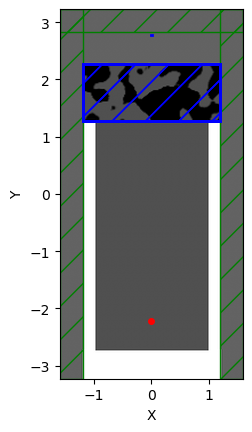

In [9]:
monitor_position, monitor_size = mp.Vector3(0, center_y_monitor_position), mp.Vector3(0.01,0)
FourierFields = mpa.FourierFields(sim,mp.Volume(center=monitor_position,size=monitor_size),mp.Ez,yee_grid=True)
ob_list = [FourierFields]

def J(fields):
    return npa.mean(npa.abs(fields) ** 2) # The index 1 corresponds to the point at the center of our monitor.

opt = mpa.OptimizationProblem(
    simulation=sim,
    objective_functions=[J],
    objective_arguments=ob_list,
    design_regions=[design_region],
    frequencies=[fcen],
    maximum_run_time=100,
)

np.random.seed(0)
rho_vector = np.random.rand(Nx * Ny)
opt.update_design([mapping(rho_vector, eta_i, 1e3)])

opt.plot2D(True)

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


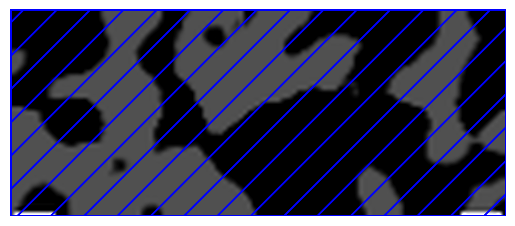

In [10]:
opt.plot2D(True, output_plane=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),))
circ = Circle((2, 2), minimum_length / 2)

plt.axis("off")
plt.show()


In [12]:
evaluation_history = []
cur_iter = [0]
numevl = 0

def f(v, gradient, beta):
    print("Current iteration: {}".format(cur_iter[0] + 1))

    f0 = []
    dJ_du = []

    global numevl

    f0_i, dJ_du_i = opt([mapping(v, eta_i, beta)])
    
    f0.append(f0_i.flatten())
    dJ_du.append(dJ_du_i)
        
        
    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, beta, np.sum(dJ_du, axis=0)
        )  # backprop

    evaluation_history.append([np.max(np.real(f0))])

    numevl += 1
    cur_iter[0] = cur_iter[0] + 1

    print("First FoM: {}".format(evaluation_history[0]))
    # print("Current f0 values: " + ", ".join(["f0_{}: {}".format(i, np.real(f0[i])) for i in range(n_dipole)]))

    return np.mean(f0)  # return the sum of the objective function values


In [13]:
algorithm = nlopt.LD_MMA
n = Nx * Ny  # number of parameters

# Initial guess
x = np.ones((n,)) * 0.5

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
ub = np.ones((Nx * Ny,))

cur_beta = 4
beta_scale = 1.5
num_betas = 8
update_factor = 10
ftol = 1e-5

for iters in range(num_betas):
    solver = nlopt.opt(algorithm, n)
    solver.set_lower_bounds(lb)
    solver.set_upper_bounds(ub)
    solver.set_max_objective(lambda a, g: f(a, g, cur_beta))
    solver.set_maxeval(update_factor)
    solver.set_ftol_rel(ftol)
    x[:] = solver.optimize(x)
    cur_beta = cur_beta * beta_scale

Current iteration: 1
Starting forward run...
-----------
Initializing structure...
time for choose_chunkdivision = 5.31673e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0517831 s
time for set

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


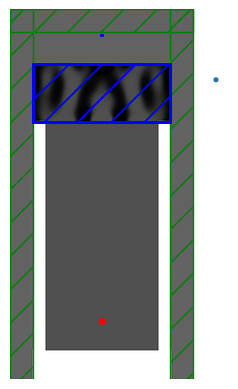

In [15]:
opt.update_design([mapping(x, eta_i, cur_beta/beta_scale)]) # cur_beta/beta_scale is the final beta in the optimization.
plt.figure()
ax = plt.gca()
opt.plot2D(True)
circ = Circle((2, 2), minimum_length / 2)
ax.add_patch(circ)
ax.axis("off")
plt.show()

In [16]:
offset = 0.01
flux_size = 0.02

input_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(center=sources.center - mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(offset, 0, 0),
                    size=mp.Vector3(0, flux_size),
                    # direction=mp.X
                    ),
        mp.FluxRegion(center=sources.center - mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y, 
                    weight=-1),
        mp.FluxRegion(center=sources.center + mp.Vector3(0, offset, 0),
                    size=mp.Vector3(flux_size, 0),
                    # direction=mp.Y
                    )
    )

out_flux = opt.sim.add_flux(
        fcen, 0, 1,
        mp.FluxRegion(
            center=mp.Vector3(0, center_y_monitor_position),
                    size=mp.Vector3(2*1/fcen,0,0),
                    # direction=mp.Y
                    )
    )

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

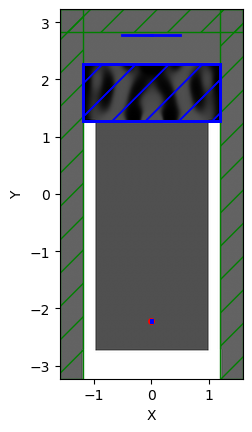

In [17]:
opt.sim.plot2D()

-----------
Initializing structure...
time for choose_chunkdivision = 2.59876e-05 s
Working in 2D dimensions.
Computational cell is 3.2 x 6.46 x 0 with resolution 50
     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
time for set_epsilon = 0.0509989 s
time for set_conductivity = 0.00202012 s
time for set_con

array([58.9091116])

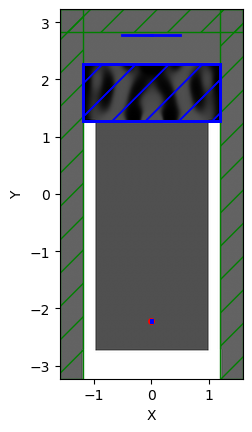

In [18]:
opt.sim.run(until_after_sources=mp.stop_when_fields_decayed(30, mp.Ez, sources.center, 1e-3))
# opt.sim.run(until=10)
# opt.sim.plot2D(output_plane=mp.Volume(center = sources.center, size = mp.Vector3(0.1,0.1)))
opt.sim.plot2D()
external_flux = mp.get_fluxes(out_flux)
box_flux = mp.get_fluxes(input_flux)

np.array(external_flux) / np.array(box_flux) * 100

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


<Axes: xlabel='X', ylabel='Y'>

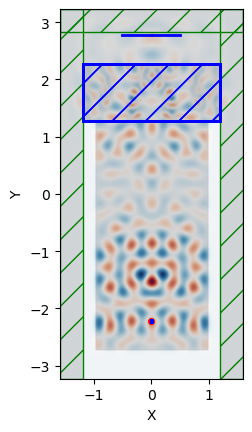

In [19]:
opt.sim.plot2D(fields=mp.Ez)

In [20]:
design_variables.weights

array([0.00195032, 0.00345399, 0.00596564, ..., 0.01326373, 0.01107816,
       0.00874048])

     block, center = (0,-2.98,0)
          size (2.4,0.5,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.73,0)
          size (2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.1025,2.1025,2.1025)
     block, center = (0,1.77,0)
          size (2.4,1,0)
          axes (1,0,0), (0,1,0), (0,0,1)
     block, center = (-1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (1.1,-0.73,0)
          size (0.2,4,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


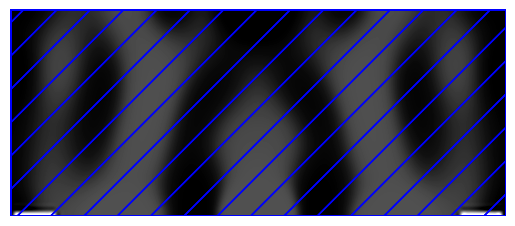

In [21]:
opt.plot2D(True, output_plane=mp.Volume(
        center=mp.Vector3(0, center_y_design, 0),
        size=mp.Vector3(design_region_width, design_region_height, 0),))
circ = Circle((2, 2), minimum_length / 2)

plt.axis("off")
plt.show()



In [ ]:
dft_fields_array = sim.get_dft_array( dft_fields, mp.Ez, 0)

이론적 임계각 θ_crit = 22.620°
계산된 θ(kx_cr) = 29.308°


/tmp/ipykernel_64167/2184544693.py:35: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


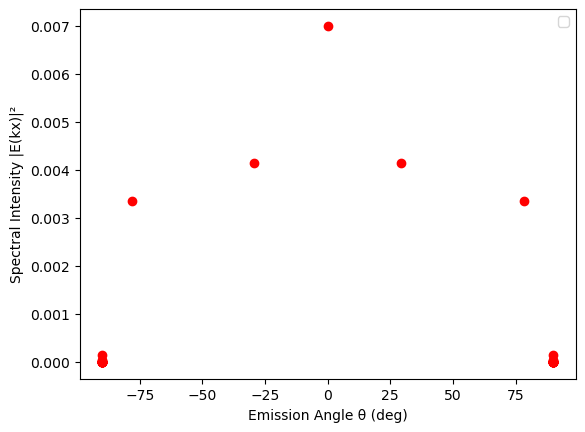

In [ ]:
# dft_fields_array: DFT 필드 데이터 (complex 1D array)
N = len(dft_fields_array)
dx = 1.0 / resolution        # 공간 샘플링 간격
k0 = 2 * np.pi * fcen        # 진공 파수

# 1) kx 배열 (rad/unit length)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 2) FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(dft_fields_array)) / N

# 3) 각도 계산 (mask 없이)
#    arcsin 안에서 ratio가 ±1을 벗어나면 nan이 되므로,
#    확인용으로는 clip을 사용해 두어도 좋습니다.
theta = np.arcsin(np.clip(kx / k0, -1, 1))  
theta_deg = np.degrees(theta)

# 4) 이론적 전반사 위치 계산
#    (예: 상부 매질 굴절률이 n2, 하부가 n1이라면 θ_crit = arcsin(n2/n1))
theta_c = np.arcsin(1 /2.6)            
kx_cr = k0 * np.sin(theta_c)

# 5) kx_cr 에 가장 가까운 인덱스
idx = np.argmin(np.abs(kx - kx_cr))

print(f"이론적 임계각 θ_crit = {np.degrees(theta_c):.3f}°")
print(f"계산된 θ(kx_cr) = {theta_deg[idx]:.3f}°")

# 6) 전체 패턴 플롯
plt.figure()
plt.plot(theta_deg, np.abs(E_k)**2, 'ro')
# plt.axvline(np.degrees(theta_c), color='k', linestyle='--', label='θ_crit')
plt.xlabel('Emission Angle θ (deg)')
plt.ylabel('Spectral Intensity |E(kx)|²')
plt.legend()
plt.show()

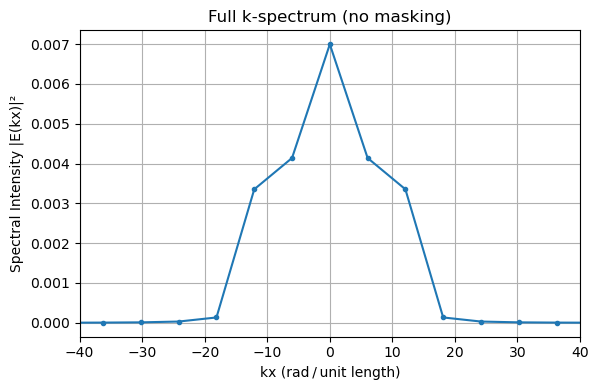

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# 1) DFT 필드 (complex 1D array)
E = dft_fields_array
N = len(E)
dx = 1.0 / resolution    # 공간 샘플 간격
k0 = 2 * np.pi * fcen    # 진공 파수

# 2) kx 벡터 (rad/unit 길이)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 3) 공간 FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(E)) / N

# 4) 세기 계산
I_k = np.abs(E_k)**2

# 5) 모든 데이터 플롯
plt.figure(figsize=(6,4))
plt.plot(kx, I_k, '.-')
plt.xlabel('kx (rad / unit length)')
plt.ylabel('Spectral Intensity |E(kx)|²')
plt.title('Full k-spectrum (no masking)')
plt.grid(True)
plt.tight_layout()
plt.xlim(-40,40)
plt.show()


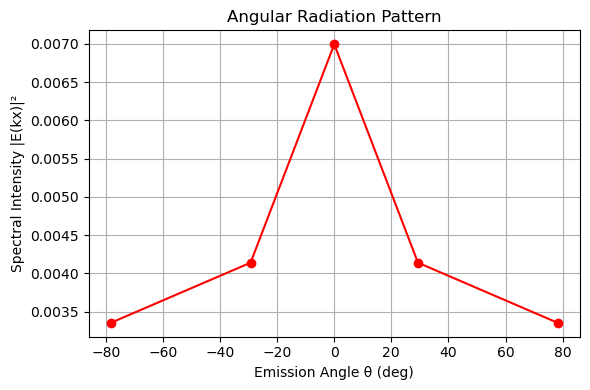

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# dft_fields_array: 시뮬레이션에서 얻은 DFT 필드 (complex 1D array)
N  = len(dft_fields_array)
dx = 1.0 / resolution      # 공간 샘플링 간격
k0 = 2 * np.pi * fcen      # 진공 파수

# 1) kx 벡터 생성 (rad/unit 길이)
kx = 2 * np.pi * np.fft.fftshift(np.fft.fftfreq(N, d=dx))

# 2) 공간 FFT → E(kx)
E_k = np.fft.fftshift(np.fft.fft(dft_fields_array)) / N

# 3) 전파 모드(Propagating modes)만 골라내기 (임계각 이내)
mask = np.abs(kx) <= k0

# 4) 각도 변환
theta = np.arcsin(kx[mask] / k0)      # 라디안
theta_deg = np.degrees(theta)         # 도(deg)

# 5) 스펙트럼 세기 계산
I_theta = np.abs(E_k[mask])**2

# 6) 방사각 분포 플롯
plt.figure(figsize=(6,4))
plt.plot(theta_deg, I_theta, '-ro')
plt.xlabel('Emission Angle θ (deg)')
plt.ylabel('Spectral Intensity |E(kx)|²')
plt.title('Angular Radiation Pattern')
plt.grid(True)
# plt.xlim(-40, 40)
plt.tight_layout()
plt.show()
